In [1]:
import warnings
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
import wandb
warnings.filterwarnings("ignore")
%matplotlib inline

C:\Users\Hp\AppData\Roaming\Python\Python310\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Step 1 : Import necessary libraries - initialize the wandb environment ###

In [2]:
# Connect to wandb (change entity name when you log)
wandb.init(project="CS6910_DL_assignment1", entity="cs23s024", name="PA1_Q1_imagesforeachclass_v1")

wandb: Currently logged in as: cs23s024. Use `wandb login --relogin` to force relogin


### Step: 2 - Importing the dataset from Keras and loading it in respective train and test dataframes ###

In [2]:
# Download dataset
(X, y), (x_test, y_test) = fashion_mnist.load_data()

# Split the X_train into a training set and validation set
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [3]:
y_train

array([5, 2, 9, ..., 6, 6, 1], dtype=uint8)

As we can see from the above, the class labels are in the form of numbers. We need to map each number to a particular class. The mapping is done in the cell below and is stored in a dictionary.

### Step 3 : Mapping from numbers to class labels ###

In [4]:
num_classes = 10
class_mapping = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}
print("Mapping successful!")

Mapping successful!


Creating a log of the unique image classes in fashion mnist dataset in wandb

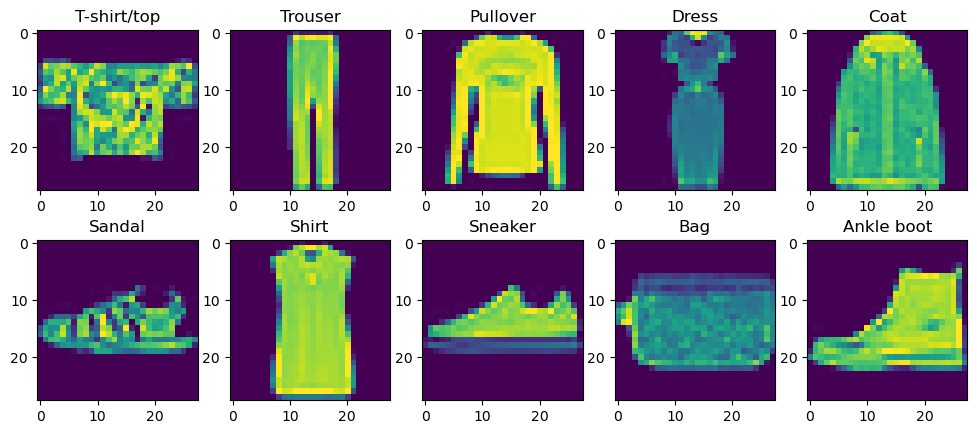

In [5]:
# Plotting a figure from each class
plt.figure(figsize=[12, 5])
img_list = []
class_list = []

for i in range(num_classes):
    position = np.argmax(y_train==i)
    image = x_train[position,:,:]
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.title(class_mapping[i])
    img_list.append(image)
    class_list.append(class_mapping[i])

#wandb.log({"Q1_class_images_unique_v1": [wandb.Image(img, caption=caption) for img, caption in zip(img_list, class_list)]})

In [7]:
wandb.finish()

### **Assignment-Q2** - Implementing a feedforward neural network which takes as input the fashion mnist dataset and outputs a probability distribution over the ten classes ###

### Step 1 : Defining activation functions ###

In [6]:
def activate(x,act_function):                                                           # Hidden layer activation function                                  

  if act_function == "sigmoid":
    return 1/(1 + np.exp(-x))

  elif act_function == "tanh": 
    return np.tanh(x) 

  elif act_function == "relu": 
    return x * (x > 0) 

def softmax(x):                                                                       # Output activation function
    return np.exp(x) / np.sum(np.exp(x)) 

### Step 2 : Defining the feedforward network ###

In [7]:
def feed_forward(x,parameters,sizes,activation):                                # feed-forward data through the network to estimate output
  
  H = {}
  A={}
  H[0] = x
 
  for i in range(1,len(sizes)-1):
    W = parameters["W"+str(i)]
    b = parameters["b"+str(i)]
    A[i] = np.dot(W,H[i-1])+b
    H[i] = activate(A[i],activation)
    
  W = parameters["W"+str(len(sizes)-1)]
  b = parameters["b"+str(len(sizes)-1)]
  A[len(sizes)-1] = np.dot(W,H[len(sizes)-2])+b
  #print("A:",A[2],"H:",H[3],len(sizes))

  y_hat = softmax(A[len(sizes)-1])
  #print(y_hat)
  
  return y_hat,A,H

### **Assignment - Q3**: Implementing the backpropogration algorithm. Optimizers: sgd, momentum based gd, nesterov accelerated gd, rmsprop,adam and nadam optimizers ###

### Step 1: Defining the loss function ###

In [8]:
def loss_compute(y,y_hat,parameters,loss_type,reg,sizes):                                               # function to compute the loss/error (both squared error and cross entropy)

  if (loss_type == "squared_error"):
    error = np.sum((y-y_hat)**2)/(2*len(y))
  elif (loss_type == "cross_entropy") :
    error = -1*np.sum(np.multiply(y,np.log(y_hat)))/len(y)
		
  reg_error = 0.0                                                                        # account for regularization to avoid overfit of data - L2 norm regularization
  for i in range(1,len(sizes)) :
    reg_error = reg_error + (reg/2)*(np.sum(np.square(parameters["W"+str(i)]))) 
  error = error + reg_error

  return error

### Step 2: Function to find derivatives and initialize gradients ###

In [9]:
def derivative(x,activation):                                                            # function to compute the derivative of hidden layer activation fn

  if activation == "sigmoid":
    return activate(x,"sigmoid")*(1-activate(x,"sigmoid"))
  elif activation == "tanh": 
    return 1. - x * x 
  elif activation == "relu": 
    return 1. * (x > 0)

def grad_init(sizes):
  
  grads={}
  layers=len(sizes)
  for i in range(1,layers):
    grads["dW" + str(i)] = np.zeros((sizes[i], sizes[i-1]))
    grads["db" + str(i)] = np.zeros((sizes[i],1))

  return grads  

### Step 3: Back propogation function ###

In [10]:
def back_prop(X,Y,Y_hat,prev_grad,A,H,parameters,sizes,loss_type,activation,reg) :               # back-propogation rule to compute the gradients of activation, pre-activation and parameters
  
  new_grad = {}
  grads = {}
  # grads = {"dH0":np.zeros((input_size,1)),"dA0":np.zeros((input_size,1))}
  for i in range(1,len(sizes)):
    grads["dW" + str(i)] = np.zeros((sizes[i], sizes[i-1]))
    grads["db" + str(i)] = np.zeros((sizes[i],1))
    grads["dA" + str(i)] = np.zeros((sizes[i],1))
    grads["dH" + str(i)] = np.zeros((sizes[i],1))

  if loss_type == "squared_error":
    grads["dH"+str(len(sizes)-1)] = (Y_hat-Y) 
    grads["dA"+str(len(sizes)-1)] = (Y_hat - Y)*Y_hat - Y_hat*(np.dot(np.transpose((Y_hat-Y)), Y_hat))

  elif loss_type=="cross_entropy" :
    grads["dH"+str(len(sizes)-1)] = -(Y/Y_hat) 
    grads["dA"+str(len(sizes)-1)] = -(Y-Y_hat)

  for i in range(len(sizes)-1, 0, -1):
    grads["dW" + str(i)] = np.dot(grads["dA" + str(i)], np.transpose(H[i-1]))
    grads["db" + str(i)] = grads["dA" + str(i)] 
    if i>1 :
      grads["dH" + str(i-1)] = np.dot(np.transpose(parameters["W" + str(i)]), grads["dA" + str(i)])
      grads["dA" + str(i-1)] = np.multiply((grads["dH" + str(i-1)]),derivative(A[i-1],activation))
    
  for i in range(1,len(sizes)):
    new_grad["dW" + str(i)] = grads["dW" + str(i)] + prev_grad["dW" + str(i)]
    new_grad["db" + str(i)] = grads["db" + str(i)] + prev_grad["db" + str(i)]
    
  return new_grad

In [11]:
# Initializations

# Data
X_train = np.array(x_train.reshape(x_train.shape[0], 784,1))         # reshape 2-D data to 1-D
X_test = np.array(x_test.reshape(x_test.shape[0], 784,1))            # reshape 2-D data to 1-D

def normalize_data(x):                                               # normalize input data
  x_norm = x.astype('float32')
  x_norm = x_norm / 255.0  
  return x_norm 

X_train = normalize_data(X_train)
X_val = X_train[-6000:]                                             # validation set input
X_train = X_train[0:54000]                                          # training set input
X_test = normalize_data(X_test)                                     # test set input


Y_train = np.zeros([len(y_train),10,1])
Y_test = np.zeros([len(y_test),10,1])

for i in range(len(y_train)):                                        # convert y from just a class number to an indicator vector (10x1)
  y = np.zeros([10, 1])
  y[y_train[i]] = 1.0
  Y_train[i] = y

Y_val = Y_train[-6000:]                                              # validation set output
Y_train = Y_train[0:54000]                                           # training set output

for i in range(len(y_test)):                                         # convert y from just a class number to an indicator vector (10x1)
  y = np.zeros([10, 1])
  y[y_test[i]] = 1.0
  Y_test[i] = y                                                      # test set output

In [12]:
def network_init(sizes,w_init):                            # function to initialize weights and biases
  parameters = {}
  for i in range(1, len(sizes)):
    if w_init == "xavier" :
      parameters["W" + str(i)] = np.random.randn(sizes[i], sizes[i-1])*np.sqrt(2./(sizes[i] + sizes[i-1]))
      parameters["b" + str(i)] = np.zeros((sizes[i],1))
    elif w_init == "random" :
      parameters["W" + str(i)] = 0.01*np.random.randn(sizes[i], sizes[i-1])
      parameters["b" + str(i)] = 0.01*np.random.randn(sizes[i],1)

  return parameters  

def update_init(sizes) :                                  # function to initialize update dictionary that changes the weights and biases
  update = {}
  for i in range(1,len(sizes)):
   update["W"+str(i)] = np.zeros((sizes[i],sizes[i-1]))
   update["b"+str(i)] = np.zeros((sizes[i],1))

  return update

In [13]:
def val_loss(y,y_hat,loss_type):                                # function to compute the loss/error (both squared error and cross entropy)
  l = 0
  if (loss_type == "squared_error"):
    l = np.sum((y-y_hat)**2)/(2*len(y))
  elif (loss_type == "cross_entropy") :
    l = -1*np.sum(np.multiply(y,np.log(y_hat)))/len(y)
  return l 

def calcAccLoss(parameters,xArr,yArr,sizes,loss_type,activation,type="val",regu=None):          #function to calculate accuracy and total loss of a model
  acc=0.0
  lossVal=0.0
  for x,y in zip(xArr,yArr):
    y_hat= feed_forward(x,parameters,sizes,activation)[0]
    if y_hat.argmax()==y.argmax():
      acc+=1
    if type=="val":
      lossVal+=val_loss(y,y_hat,loss_type)
    elif type=="trng":
      lossVal+=loss_compute(y,y_hat,parameters,loss_type,regu,sizes)
  acc=acc/len(xArr)
  return (acc,lossVal)


In [14]:
#momentum Gradient descent
def momentum_GD(X_train,Y_train,activation,n_epoch,sizes,lr,reg,w_init,loss_type,minibatch_size=1,log=False) :

   steps=0                                                                                      #used to count number of updates to parameters
   parameters = network_init(sizes,w_init)
   update = update_init(sizes)
   gamma = 0.9
   for n in range(n_epoch):

     for j in range(0, X_train.shape[0], minibatch_size):                                       #minibatch division 
       X_mini = X_train[j:j + minibatch_size]
       Y_mini = Y_train[j:j + minibatch_size]
       grads = grad_init(sizes)

       for x,y in zip(X_mini,Y_mini):
         y_hat,A,H = feed_forward(x,parameters,sizes,activation)                                 
         grads = back_prop(x,y,y_hat,grads,A,H,parameters,sizes,loss_type,activation,reg)

       for i in range(1,len(sizes)) :                                                           #updating the parameters
         update["W"+str(i)] = gamma*update["W"+str(i)] + lr*grads["dW"+str(i)]                  
         update["b"+str(i)] = gamma*update["b"+str(i)] + lr*grads["db"+str(i)]
         parameters["W"+str(i)] = (1-lr*reg)*parameters["W"+str(i)] - update["W"+str(i)]
         parameters["b"+str(i)] = (1-lr*reg)*parameters["b"+str(i)] - update["b"+str(i)]
       
       steps=steps+1
       if steps==10000:                                                                         #log every 10000 updates
        acc,lossTot=calcAccLoss(parameters,X_train,Y_train,sizes,loss_type,activation,type="trng",regu=reg)          #calculating accuracy and loss
        accVal,lossTotVal=calcAccLoss(parameters,X_val,Y_val,sizes,loss_type,activation)

        wandb.log({"Accuracy":acc,"Loss":lossTot,"Accuracy_val":accVal,"Loss_val":lossTotVal,"Epoch":n,"n_datatrain":j + minibatch_size+n*54000}) #logging
        steps=0
  
   return parameters        

#Nesterov acceleracted GD
def nesterov_accelerated_GD(X_train,Y_train,activation,n_epoch,sizes,lr,reg,w_init,loss_type,minibatch_size=1,log=False) :
  steps=0
  parameters = network_init(sizes,w_init)
  update = update_init(sizes)
  gamma = 0.9
  for n in range(n_epoch):

    for j in range(0, X_train.shape[0], minibatch_size):
      X_mini = X_train[j:j + minibatch_size]
      Y_mini = Y_train[j:j + minibatch_size]
      

      grads = grad_init(sizes)
      for i in range(1,len(sizes)):                                                       #perform update before back propogation
        update["W"+str(i)] = gamma*update["W"+str(i)]
        update["b"+str(i)] = gamma*update["b"+str(i)]
        parameters["W"+str(i)] = (1-lr*reg)*parameters["W"+str(i)] - update["W"+str(i)]
        parameters["b"+str(i)] = (1-lr*reg)*parameters["b"+str(i)] - update["b"+str(i)]        

      for x,y in zip(X_mini,Y_mini):
        y_hat,A,H = feed_forward(x,parameters,sizes,activation)
        grads = back_prop(x,y,y_hat,grads,A,H,parameters,sizes,loss_type,activation,reg)
        
      for k in range(1,len(sizes)) :
        update["W"+str(k)] = gamma*update["W"+str(k)] + lr*grads["dW"+str(k)]
        update["b"+str(k)] = gamma*update["b"+str(k)] + lr*grads["db"+str(k)]
        parameters["W"+str(k)] = (1-lr*reg)*parameters["W"+str(k)] - update["W"+str(k)]
        parameters["b"+str(k)] = (1-lr*reg)*parameters["b"+str(k)] - update["b"+str(k)]
      steps=steps+1
      if steps==10000:
        if log:
          acc,lossTot=calcAccLoss(parameters,X_train,Y_train,sizes,loss_type,activation,type="trng",regu=reg)     
          accVal,lossTotVal=calcAccLoss(parameters,X_val,Y_val,sizes,loss_type,activation)

          wandb.log({"Accuracy":acc,"Loss":lossTot,"Accuracy_val":accVal,"Loss_val":lossTotVal,"Epoch":n,"n_datatrain":j + minibatch_size+n*54000})
        steps=0   
    
  return parameters

#stochastic GD
def stochastic_GD(X_train,Y_train,activation,n_epoch,sizes,lr,reg,w_init,loss_type,minibatch_size=1,log=False) :

  steps=0
  parameters = network_init(sizes,w_init)
  update = update_init(sizes)
  gamma = 0.9
  for n in range(n_epoch):

    for j in range(0, X_train.shape[0], minibatch_size):                                        #minibatch division
      X_mini = X_train[j:j + minibatch_size]
      Y_mini = Y_train[j:j + minibatch_size]
      
      grads = grad_init(sizes)
      for x,y in zip(X_mini,Y_mini):
        y_hat,A,H = feed_forward(x,parameters,sizes,activation)
        grads = back_prop(x,y,y_hat,grads,A,H,parameters,sizes,loss_type,activation,reg)
        
      for i in range(1,len(sizes)-1) :                                                          #updating the parameters
        parameters["W"+str(i)] = (1-lr*reg)*parameters["W"+str(i)] - lr*grads["dW"+str(i)]
        parameters["b"+str(i)] = (1-lr*reg)*parameters["b"+str(i)] - lr*grads["db"+str(i)]
      steps=steps+1
      if steps==10000:
        if log:
          acc,lossTot=calcAccLoss(parameters,X_train,Y_train,sizes,loss_type,activation,type="trng",regu=reg)     
          accVal,lossTotVal=calcAccLoss(parameters,X_val,Y_val,sizes,loss_type,activation)

          wandb.log({"Accuracy":acc,"Loss":lossTot,"Accuracy_val":accVal,"Loss_val":lossTotVal,"Epoch":n,"n_datatrain":j + minibatch_size+n*54000})
        steps=0   

  return parameters        

#rmsprop GD
def rmsprop_GD(X_train,Y_train,activation,n_epoch,sizes,lr,reg,w_init,loss_type,minibatch_size=1,log=False) :
  
  steps=0
  parameters = network_init(sizes,w_init)
  update = update_init(sizes)
  v = update_init(sizes)

  betal = 0.99 #check this
  eps = 1e-8

  for n in range(n_epoch):

    for j in range(0, X_train.shape[0], minibatch_size):
      X_mini = X_train[j:j + minibatch_size]
      Y_mini = Y_train[j:j + minibatch_size]
      
      grads = grad_init(sizes)
      for x,y in zip(X_mini,Y_mini):
        y_hat,A,H = feed_forward(x,parameters,sizes,activation)
        grads = back_prop(x,y,y_hat,grads,A,H,parameters,sizes,loss_type,activation,reg)

      for i in range(1,len(sizes)-1) :                                                                   #updating the parameters
        v["W"+str(i)] = betal*v["W"+str(i)] + (1-betal)*grads["dW"+str(i)]**2                            #v_w update  
        v["b"+str(i)] = betal*v["b"+str(i)] + (1-betal)*grads["db"+str(i)]**2                            #v_b update

        update["W"+str(i)]=lr*np.multiply(np.reciprocal(np.sqrt(v["W"+str(i)]+eps)),grads["dW"+str(i)])                 
        update["b"+str(i)]=lr*np.multiply(np.reciprocal(np.sqrt(v["b"+str(i)]+eps)),grads["db"+str(i)])
        
        parameters["W"+str(i)] = (1-lr*reg)*parameters["W"+str(i)] - update["W"+str(i)]
        parameters["b"+str(i)] = (1-lr*reg)*parameters["b"+str(i)] - update["b"+str(i)]
      steps=steps+1
      if steps==10000:
        if log:
          acc,lossTot=calcAccLoss(parameters,X_train,Y_train,sizes,loss_type,activation,type="trng",regu=reg)     
          accVal,lossTotVal=calcAccLoss(parameters,X_val,Y_val,sizes,loss_type,activation)

          wandb.log({"Accuracy":acc,"Loss":lossTot,"Accuracy_val":accVal,"Loss_val":lossTotVal,"Epoch":n,"n_datatrain":j + minibatch_size+n*54000})
        steps=0   

  return parameters          

#Adam GD
def adam_GD(X_train,Y_train,activation,n_epoch,sizes,lr,reg,w_init,loss_type,minibatch_size=1,log=False) :
  steps=0
  parameters = network_init(sizes,w_init)
  update = update_init(sizes)
  m = update_init(sizes)
  v = update_init(sizes)

  beta1 = 0.9
  beta2 = 0.999
  eps = 1e-8
  for n in range(n_epoch):

    for j in range(0, X_train.shape[0], minibatch_size):
      X_mini = X_train[j:j + minibatch_size]
      Y_mini = Y_train[j:j + minibatch_size]
      
      grads = grad_init(sizes)                                          
      for x,y in zip(X_mini,Y_mini):
        y_hat,A,H = feed_forward(x,parameters,sizes,activation)
        grads = back_prop(x,y,y_hat,grads,A,H,parameters,sizes,loss_type,activation,reg)
        
      for i in range(1,len(sizes)-1) :                                                    #updating the parameters
        m["W"+str(i)] = beta1*m["W"+str(i)] + (1-beta1)*grads["dW"+str(i)]                #m_w update
        m["b"+str(i)] = beta1*m["b"+str(i)] + (1-beta1)*grads["db"+str(i)]                #m_b update

        v["W"+str(i)] = beta2*v["W"+str(i)] + (1-beta2)*grads["dW"+str(i)]**2             #v_w update    
        v["b"+str(i)] = beta2*v["b"+str(i)] + (1-beta2)*grads["db"+str(i)]**2             #v_b update

        #cumulative average
        m_w_hat = m["W"+str(i)]/(1-np.power(beta1,n+1))                                   
        m_b_hat = m["b"+str(i)]/(1-np.power(beta1,n+1))
        v_w_hat = v["W"+str(i)]/(1-np.power(beta2,n+1))
        v_b_hat = v["b"+str(i)]/(1-np.power(beta2,n+1))


        update["W"+str(i)]=lr*np.multiply(np.reciprocal(np.sqrt(v_w_hat+eps)),m_w_hat)
        update["b"+str(i)]=lr*np.multiply(np.reciprocal(np.sqrt(v_b_hat+eps)),m_b_hat)

        parameters["W"+str(i)] = (1-lr*reg)*parameters["W"+str(i)] - update["W"+str(i)]
        parameters["b"+str(i)] = (1-lr*reg)*parameters["b"+str(i)] - update["b"+str(i)]
      
    
      steps=steps+1
      if steps==10000:
        if log:
          acc,lossTot=calcAccLoss(parameters,X_train,Y_train,sizes,loss_type,activation,type="trng",regu=reg)     
          accVal,lossTotVal=calcAccLoss(parameters,X_val,Y_val,sizes,loss_type,activation)

          wandb.log({"Accuracy":acc,"Loss":lossTot,"Accuracy_val":accVal,"Loss_val":lossTotVal,"Epoch":n,"n_datatrain":j + minibatch_size+n*54000})
        steps=0     

  return parameters   


#Nadam GD
def nadam_GD(X_train,Y_train,activation,n_epoch,sizes,lr,reg,w_init,loss_type,minibatch_size=1,log=False) :
  steps=0
  parameters = network_init(sizes,w_init)
  update = update_init(sizes)
  m = update_init(sizes)
  v = update_init(sizes)

  beta1 = 0.9
  beta2 = 0.999
  eps = 1e-8

  for n in range(n_epoch):

    for j in range(0, X_train.shape[0], minibatch_size):
      X_mini = X_train[j:j + minibatch_size]
      Y_mini = Y_train[j:j + minibatch_size]
      grads = grad_init(sizes)

      for x,y in zip(X_mini,Y_mini):
        y_hat,A,H = feed_forward(x,parameters,sizes,activation)
        grads = back_prop(x,y,y_hat,grads,A,H,parameters,sizes,loss_type,activation,reg)

      for i in range(1,len(sizes)-1) :                                                    #updating the parameters
        m["W"+str(i)] = beta1*m["W"+str(i)] + (1-beta1)*grads["dW"+str(i)]                #m_w update
        m["b"+str(i)] = beta1*m["b"+str(i)] + (1-beta1)*grads["db"+str(i)]                #m_b update

        v["W"+str(i)] = beta2*v["W"+str(i)] + (1-beta2)*grads["dW"+str(i)]**2             #v_w update    
        v["b"+str(i)] = beta2*v["b"+str(i)] + (1-beta2)*grads["db"+str(i)]**2             #v_b update

        #cumulative average
        m_w_hat = m["W"+str(i)]/(1-np.power(beta1,n+1))                                   
        m_b_hat = m["b"+str(i)]/(1-np.power(beta1,n+1))
        v_w_hat = v["W"+str(i)]/(1-np.power(beta2,n+1))
        v_b_hat = v["b"+str(i)]/(1-np.power(beta2,n+1))


        update["W"+str(i)]=lr*np.multiply(np.reciprocal(np.sqrt(v_w_hat+eps)),(beta1*m_w_hat+(1-beta1)*grads["dW"+str(i)]))*(1/(1-np.power(beta1,n+1)))
        update["b"+str(i)]=lr*np.multiply(np.reciprocal(np.sqrt(v_b_hat+eps)),(beta1*m_b_hat+(1-beta1)*grads["db"+str(i)]))*(1/(1-np.power(beta1,n+1)))

        parameters["W"+str(i)] = (1-lr*reg)*parameters["W"+str(i)] - update["W"+str(i)]
        parameters["b"+str(i)] = (1-lr*reg)*parameters["b"+str(i)] - update["b"+str(i)]
      steps=steps+1
      if steps==10000:
        if log:
          acc,lossTot=calcAccLoss(parameters,X_train,Y_train,sizes,loss_type,activation,type="trng",regu=reg)     
          accVal,lossTotVal=calcAccLoss(parameters,X_val,Y_val,sizes,loss_type,activation)

          wandb.log({"Accuracy":acc,"Loss":lossTot,"Accuracy_val":accVal,"Loss_val":lossTotVal,"Epoch":n,"n_datatrain":j + minibatch_size+n*54000})
        steps=0   

  return parameters   

In [15]:
#function to select optimizer
def do_GD(X_train,Y_train,optimizer,activation,hl_size,input_size,output_size,n_epoch,lr,reg,w_init,loss_type,minibatch_size=1,logging=False):
  sizes = hl_size.copy() 
  sizes.insert(0,input_size)
  sizes.append(output_size)

  if optimizer=="sgd":
    return(stochastic_GD(X_train,Y_train,activation,n_epoch,sizes,lr,reg,w_init,loss_type,minibatch_size=1,log=logging))
  elif optimizer=="momentum":
    return(momentum_GD(X_train,Y_train,activation,n_epoch,sizes,lr,reg,w_init,loss_type,minibatch_size=1,log=logging))
  elif optimizer=="nesterov":
    return(nesterov_accelerated_GD(X_train,Y_train,activation,n_epoch,sizes,lr,reg,w_init,loss_type,minibatch_size=1,log=logging))
  elif optimizer=="rmsprop":
    return(rmsprop_GD(X_train,Y_train,activation,n_epoch,sizes,lr,reg,w_init,loss_type,minibatch_size=1,log=logging))
  elif optimizer=="adam":
    return(adam_GD(X_train,Y_train,activation,n_epoch,sizes,lr,reg,w_init,loss_type,minibatch_size=1,log=logging))
  elif optimizer=="nadam":
    return(nadam_GD(X_train,Y_train,activation,n_epoch,sizes,lr,reg,w_init,loss_type,minibatch_size=1,log=logging))

In [16]:
#training function to sweep with wandb
def train():

  hyperparameter_defaults=dict(
      input_size = 784,                                       
      output_size = 10,                                                    
      n_epoch = 5,                                            
      n_hiddenlayer = 3,                               
      hl= [64,64,64],
      reg = 0.0005,      
      lr = 1e-3,                                              
      optimizer = "momentum",                      
      batch_size = 64,       
      initialization = "xavier",      
      loss_type = "cross_entropy" 
      
  )
  run = wandb.init(config=hyperparameter_defaults)
  config=wandb.config  
  name_str = "opt_"+str(config['optimizer'])+"_lr"+str(config["lr"])+"_reg"+str(config["reg"])+"_hl"+str(config["n_hiddenlayer"])+"_hlsize"+str(config['hl_size'])+"_epoch"+str(config['n_epoch'])+"_bs"+str(config['batch_size'])+"_loss_type"+str(config["loss_type"])+"_init"+str(config["initialization"])+"_losstype"+str(config["loss_type"])                      # Code for determining run names here
  run.name = name_str
  
  
  
  
  output_size=10
  input_size = 784                                      
  config.hl=[config.hl_size for i in range(config.n_hiddenlayer)]   #hidden layer sizes array creation
  parameters=do_GD(X_train,Y_train,config.optimizer,config.activation,config.hl,config.input_size,config.output_size,config.n_epoch,config.lr,config.reg,config.initialization,config.loss_type,config.batch_size,logging=True)


In [17]:
def sweeper(sweep_config,proj_name):
  sweep_id=wandb.sweep(sweep_config,project=proj_name)
  wandb.agent(sweep_id,train,project=proj_name)

#### Assignment Q6: Hyperparameter sweep using bayes method ###

In [22]:
#sweep dictionary
sweep_config={
    'method':'bayes',
    'name':'second_sweep_0903',
    'metric':{
        'name':'accuracy',
        'goal':'maximize'},

}

parameters_dict={
    'optimizer':{
        'values':['nadam','sgd', 'momentum', 'nesterov', 'rmsprop', 'adam']
    },
    'lr':{
        'values':[1e-3,1e-5]
    },
    'reg':{
        'values':[5e-4,0,5e-1]
    },
    'n_hiddenlayer':{
        'values':[3,4,5]
    },
    'hl_size':{
      'values':[128,32,64]  
    },
    'batch_size':{
        'values':[64,32,128]
    },
    'loss_type':{
        'values':['cross_entropy','squared_error']
    },
    'initialization':{
        'values':['xavier','random']
    },
    'activation':{
        'values':['relu','sigmoid','tanh']
    },
    'n_epoch':{
        'values':[5]
    }
}

sweep_config['parameters']=parameters_dict

In [18]:
proj_name='CS6910_DL_assignment1'

In [24]:
sweep_id=wandb.sweep(sweep_config,project=proj_name)

Create sweep with ID: 1s1xgap1
Sweep URL: https://wandb.ai/srividhya/CS6910_DL_assignment1/sweeps/1s1xgap1


In [ ]:
sweeper(sweep_config,proj_name)

Create sweep with ID: 4s10gpe0
Sweep URL: https://wandb.ai/srividhya/CS6910_DL_assignment1/sweeps/4s10gpe0


wandb: Agent Starting Run: ah73wd3o with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005
wandb: Currently logged in as: cs23s024 (srividhya). Use `wandb login --relogin` to force relogin


Accuracy,▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy_val,▂▂█▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆██████
Loss,██▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
Loss_val,█▆▆▇█▇▆▃▅▇▆▄▃▃▅▅▄▃▁▃▅▃▃▁▂▃▃
n_datatrain,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
Accuracy,0.10006
Accuracy_val,0.09767
Epoch,4
Loss,2655.12763
Loss_val,270.00043


wandb: Agent Starting Run: x0f8zws9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0


Accuracy,▄▄█▄▄▂█▄▄▄▃▄▅▄▃▅█▄▂▄▃▄▂▁▂▂▂
Accuracy_val,▅▁▁▁█▂▁█▁▁▇▅▅▅▇▅▁▁▂▁▇█▆▄▂▇▇
Epoch,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆██████
Loss,▂▆▁▂▃▄▃▂▆▂▄▅▃▆▂▂▄▃▁▄▂▆▄█▅▆▂
Loss_val,▂▅▂▂▂▄▃▁▇▃▃▄▃▅▂▁▄▃▂▄▁▅▄█▅▅▂
n_datatrain,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
Accuracy,0.09965
Accuracy_val,0.10183
Epoch,4
Loss,12439.95635
Loss_val,1382.11663


wandb: Agent Starting Run: defslhpn with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: random
wandb: 	loss_type: squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0


Accuracy,▁▅▆▆▅▆▇▇▆▆▇▆▇█▇▇▇█▇█▇█▇████
Accuracy_val,▁▅▆▆▅▅▇▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇██
Epoch,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆██████
Loss,█▅▃▃▄▄▂▂▃▃▂▃▂▂▂▂▃▂▂▂▃▂▃▂▂▁▁
Loss_val,█▅▃▄▄▄▃▃▄▃▂▃▃▂▃▂▃▂▂▂▃▂▃▂▂▁▁
n_datatrain,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
Accuracy,0.87752
Accuracy_val,0.87967
Epoch,4
Loss,503.33321
Loss_val,54.62043


wandb: Agent Starting Run: 9pcwjyk3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nesterov
wandb: 	reg: 0.5


Accuracy,▄▁▃▃▂▆█▂▂▁▁▄▅▅▃▆▇▅▄▅▂▁▃▄▃▃▄
Accuracy_val,▄▂▂▂▃▆█▃▂▁▁▄▅▅▃▆▆▅▃▄▂▁▃▄▃▃▄
Epoch,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆██████
Loss,███▆▆▁▄▆▆▃▇▂▃▆▅▃▃▂█▂▇▃▂▂▅▅█
Loss_val,▁▂▂▃▂▅▃▂▄▄▄█▅▃▃▃▃▄▂▄▁▃▃▃▃▃▁
n_datatrain,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
Accuracy,0.23543
Accuracy_val,0.236
Epoch,4
Loss,86176.77375
Loss_val,1174.31247


wandb: Agent Starting Run: 19jc64ru with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.0005


Accuracy,▄▄█▄▄▂█▄▄▄▃▄▅▄▃▅█▁▂▄▃▄▂▁▂▂▂
Accuracy_val,▅▁▁▁█▂▁█▁▁▇▅▅▅▇▅▁▄▂▁▇█▆▄▂▇▇
Epoch,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆██████
Loss,██▇▇▇▆▆▅▆▅▅▅▄▅▄▃▄▃▃▃▂▃▂▃▂▂▁
Loss_val,▂▅▂▃▂▃▃▁▇▃▃▃▃▅▂▁▅▃▂▄▁▅▄█▄▅▁
n_datatrain,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
Accuracy,0.09965
Accuracy_val,0.10183
Epoch,4
Loss,2459.72807
Loss_val,270.03514


wandb: Agent Starting Run: ez308qns with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: nadam
wandb: 	reg: 0


Accuracy,▁▁▆▇▆▇██▆▇▇▇█▇▇███████████▇
Accuracy_val,▂▁▆▇▆▇▇█▇▇▇▇█▇▇█████▇█▇████
Epoch,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆██████
Loss,▇█▅▅▅▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Loss_val,▇█▅▅▅▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁
n_datatrain,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
Accuracy,0.37209
Accuracy_val,0.3695
Epoch,4
Loss,2365.48648
Loss_val,262.83831


wandb: Agent Starting Run: q0lfahyu with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.5


wandb: Network error (ConnectionError), entering retry loop.


Accuracy,▇▇████████▄▅▄▅▄▅▆▅▃▂▂▂▃▃▂▁▁
Accuracy_val,▇▇▇███████▄▅▄▅▄▄▆▄▃▂▂▂▃▃▂▁▁
Epoch,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆██████
Loss,█▇▆▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▂▂▂▃▃▃▄
Loss_val,▃▂▂▁▁▁▁▁▁▁▅▅▆▅▅▅▅▅▆███▇████
n_datatrain,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
Accuracy,0.40557
Accuracy_val,0.4015
Epoch,4
Loss,5736038.067
Loss_val,208.80453


wandb: Agent Starting Run: uqlh2kor with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nesterov
wandb: 	reg: 0


Accuracy,▁▁▁▁▂▄▅▅▆▆▇▇▇▇▇▇▇▇█████████
Accuracy_val,▁▁▁▁▂▄▅▅▆▆▇▇▇▇▇▇▇▇██▇██████
Epoch,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆██████
Loss,███▇▇▆▅▄▄▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
Loss_val,███▇▆▆▅▄▄▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
n_datatrain,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
Accuracy,0.8367
Accuracy_val,0.83683
Epoch,4
Loss,645.87866
Loss_val,72.5118


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yk3ay7dt with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: sgd
wandb: 	reg: 0


Accuracy,▁▅▅▆▆▇▇▇▇▆▇▇▆▇█▇██▇█▇█▇████
Accuracy_val,▁▄▅▆▆▇▆▇▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇████
Epoch,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆██████
Loss,█▅▄▃▃▃▃▂▂▃▂▂▃▂▂▂▁▁▂▁▁▁▂▁▁▁▁
Loss_val,█▅▄▄▃▃▃▃▃▃▂▂▄▂▂▂▂▂▂▂▂▂▂▁▁▁▁
n_datatrain,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
Accuracy,0.88159
Accuracy_val,0.88617
Epoch,4
Loss,1772.29167
Loss_val,186.93663


wandb: Agent Starting Run: c0yvfz7w with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nesterov
wandb: 	reg: 0.5


Accuracy,▄▄█▅▄▂█▄▄▄▃▂▅▄▄▅█▄▂▃▅▄▂▁▄▂▂
Accuracy_val,▅▁▁▅█▂▁█▁▁▇▂▅▅▅▅▁▁▂▇▅█▆▄█▇▇
Epoch,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆██████
Loss,▂▇▁▁▄▅▄▁▆▃▆▇▄▇▃▂▄▅▂▅▂▇▄█▅▆▃
Loss_val,▂▆▃▂▃▄▄▁▇▄▄▅▄▅▃▃▅▆▃▅▂▆▄█▄▄▃
n_datatrain,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
Accuracy,0.09965
Accuracy_val,0.10183
Epoch,4
Loss,2445.82193
Loss_val,270.03659


wandb: Agent Starting Run: a80zwwaz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 128
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: momentum
wandb: 	reg: 0


Accuracy,▆▆▆▇█▆▆▆▆▆▆▆▁▆▇▇█▇▇▇█▆▆▄▆▆█
Accuracy_val,▆▆▆▇█▆▆▆▆▆▆▆▁▆▆▇▇▆▆▇█▆▆▅▆▆▇
Epoch,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆██████
Loss,█▆▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss_val,█▆▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_datatrain,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
Accuracy,0.1212
Accuracy_val,0.11517
Epoch,4
Loss,2429.99869
Loss_val,270.00336


wandb: Agent Starting Run: o6a0gojy with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0.5


Accuracy,▁▄▆▆▇▇▇████████████████████
Accuracy_val,▁▄▆▆▇▇▇████████████████████
Epoch,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆██████
Loss,█▇▇▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Loss_val,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_datatrain,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
Accuracy,0.75917
Accuracy_val,0.75117
Epoch,4
Loss,1032006.84801
Loss_val,524.80618


wandb: Agent Starting Run: uo9x6vyv with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nesterov
wandb: 	reg: 0.0005


Accuracy,▁▁▁▁▁▁▁▂▄▅▅▅▆▆▇▇▇▇▇▇▇██████
Accuracy_val,▁▁▁▁▁▁▁▂▄▅▅▅▆▆▇▇▇▇▇▇▇██▇███
Epoch,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆██████
Loss,▃▃▃▃▃▃▃▃▁▁▁▂▃▃▃▄▅▅▅▆▆▆▇▇▇██
Loss_val,████████▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
n_datatrain,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
Accuracy,0.76944
Accuracy_val,0.77017
Epoch,4
Loss,21190.65872
Loss_val,394.37728


wandb: Agent Starting Run: 5g5tcusu with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: adam
wandb: 	reg: 0.5


Accuracy,▃▄▆█▆▄▂▂▅▂▆▂▂▂▂▂▁▂▂▂▂▂▂▂▂▁▂
Accuracy_val,▂▄▆█▆▄▂▂▅▂▆▂▂▂▂▂▁▂▂▂▂▂▂▂▂▁▂
Epoch,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆██████
Loss,▇▇▇▇█▄▆▆▆▆▄▄▄▄▄▄▂▂▂▂▂▁▁▁▁▁▁
Loss_val,▄▄▃▄▁▅▂▂▁▁▃▄▄▄▄▄▆▆▆▆▆▇█████
n_datatrain,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
Accuracy,0.19913
Accuracy_val,0.20267
Epoch,4
Loss,860301.32146
Loss_val,268.49755


wandb: Agent Starting Run: 54vmfkqg with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	hl_size: 64
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nesterov
wandb: 	reg: 0.5


Accuracy,▄▄▄▅▄▂█▅▄▄▃▂▅▄▄▅█▄▂▃▅▄▂▁▄▂▂
Accuracy_val,▅▁▁▅█▂▁▅▁▁▇▂▅▅▅▅▁▁▂▇▅█▆▄█▇▇
Epoch,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆██████
Loss,▃█▁▁▅▆▄▁▆▃▇█▅▇▃▃▄▆▂▅▃▆▄█▅▆▃
Loss_val,▂▆▃▂▃▅▄▁▇▄▄▆▅▅▄▃▅▆▃▆▂▆▄█▄▄▃
n_datatrain,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
Accuracy,0.09965
Accuracy_val,0.10183
Epoch,4
Loss,12437.76821
Loss_val,1382.00217


wandb: Agent Starting Run: lk6g6ao4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: xavier
wandb: 	loss_type: squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


Accuracy,▂▆▇▇██▆▄▃▄▄▅▃▂▁▂▂▂▃▃▃▃▄▅▅▅▅
Accuracy_val,▂▆▇▇██▆▄▃▄▄▅▃▂▁▂▂▂▃▃▃▃▄▅▅▅▅
Epoch,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆██████
Loss,▁▁▁▁▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇██
Loss_val,▇▃▁▁▃▅▆▇▇██▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▄
n_datatrain,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
Accuracy,0.49493
Accuracy_val,0.494
Epoch,4
Loss,11273.0885
Loss_val,204.04895


wandb: Agent Starting Run: 6fesks7k with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: sgd
wandb: 	reg: 0.0005


Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy_val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆██████
Loss,██▇▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁
Loss_val,▁███████████████▁████▁▁████
n_datatrain,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
Accuracy,0.09985
Accuracy_val,0.10133
Epoch,4
Loss,12463.38724
Loss_val,1381.53669


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: atdbb6z5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


Accuracy,▁▁▁▁▁▁▁▁▃▂▃▁▁██████████▃███
Accuracy_val,▇▇▇▇▇▇▇▇▅▁▅▇▇▁▁▁▁▁▁▁▁▁▁█▁▁▁
Epoch,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆██████
Loss,█▇▇▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Loss_val,▄▂▁▄▅▃▃▁▄▆▄▃▃▄▇▆▅▅▄▇█▅▆▅▆█▆
n_datatrain,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
Accuracy,0.10093
Accuracy_val,0.09767
Epoch,4
Loss,15087.15251
Loss_val,1381.56243


wandb: Agent Starting Run: afnn1j7s with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


Accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█▇█▇██████
Accuracy_val,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇██▇█▇██████
Epoch,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆██████
Loss,█▃▂▁▁▁▁▁▂▂▂▃▃▃▃▄▄▄▅▅▆▅▆▆▆▆▆
Loss_val,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁
n_datatrain,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
Accuracy,0.86341
Accuracy_val,0.85967
Epoch,4
Loss,7846.65474
Loss_val,61.07314


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fuzuj1p1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


Accuracy,▁▅▅▅▆▆▇▇▇▇▇▇▇██▇█▇██▇▇▇████
Accuracy_val,▁▄▄▅▆▅▇▇▇▇▇▇▇▇▇▇█▇▇█▇▇▇█▇██
Epoch,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆██████
Loss,▁▁▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
Loss_val,█▅▅▄▄▄▃▂▃▂▂▂▂▂▂▂▂▂▁▁▃▂▂▁▁▁▁
n_datatrain,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
Accuracy,0.86974
Accuracy_val,0.8755
Epoch,4
Loss,317858.45963
Loss_val,57.75569


wandb: Agent Starting Run: 3rt7ticd with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: rmsprop
wandb: 	reg: 0.0005


Accuracy,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇█▇██████
Accuracy_val,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇███
Epoch,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆██████
Loss,█▄▂▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▅▄▅▅▅▆▆▆▆
Loss_val,█▆▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁
n_datatrain,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
Accuracy,0.86661
Accuracy_val,0.86633
Epoch,4
Loss,9681.32037
Loss_val,59.78317


wandb: Agent Starting Run: avvk7sun with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 4
wandb: 	optimizer: adam
wandb: 	reg: 0.5


Accuracy,▁▄▅▆▇▇▇▇███████████████████
Accuracy_val,▁▄▅▆▇▇▇▇███████████████████
Epoch,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆██████
Loss,█▇▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
Loss_val,█▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_datatrain,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
Accuracy,0.70611
Accuracy_val,0.6985
Epoch,4
Loss,873126.03314
Loss_val,595.90688


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jkadssux with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: nadam
wandb: 	reg: 0.5


Accuracy,▇█▅▃▄▅▄▄▄▄▄▄▄▃▃▃▃▃▂▃▂▂▂▁▁▁▁
Accuracy_val,▇█▅▃▅▅▄▄▄▄▄▄▄▄▄▃▃▃▂▃▂▂▂▁▁▁▁
Epoch,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆██████
Loss,█▇▇▇█▇▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁
Loss_val,▂▁▅▇▄▄▅▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
n_datatrain,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
Accuracy,0.66794
Accuracy_val,0.66833
Epoch,4
Loss,2572660.89974
Loss_val,147.89071


wandb: Agent Starting Run: 69fge7tr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 5
wandb: 	optimizer: momentum
wandb: 	reg: 0


Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy_val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆██████
n_datatrain,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
Accuracy,0.10006
Accuracy_val,0.09767
Epoch,4
Loss,nan
Loss_val,nan
n_datatrain,270000


wandb: Agent Starting Run: qkx1b8bj with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	hl_size: 128
wandb: 	initialization: xavier
wandb: 	loss_type: cross_entropy
wandb: 	lr: 1e-05
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: momentum
wandb: 	reg: 0.5


Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Accuracy_val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆██████
n_datatrain,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
Accuracy,0.10006
Accuracy_val,0.09767
Epoch,4
Loss,nan
Loss_val,nan
n_datatrain,270000


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 71yb2xgy with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	hl_size: 32
wandb: 	initialization: random
wandb: 	loss_type: squared_error
wandb: 	lr: 0.001
wandb: 	n_epoch: 5
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0


#### Assignment Q7: Confusion matrix for the validation dataset ####

In [16]:
#confusion matrix and accuracy for test values
hyperparameter_final=dict(
    input_size = 784,                                       
    output_size = 10,                                                    
    n_epoch = 5,                                            
    n_hiddenlayer = 3,                               
    hl= [128,128,128],
    reg = 0,      
    lr = 1e-5,                                              
    optimizer = "nadam",                      
    batch_size = 128,       
    initialization = "xavier",      
    loss_type = "cross_entropy",
    activation="relu" 
    
)

wandb.init(config=hyperparameter_final,project=proj_name)
config=wandb.config
parameters_test=do_GD(X_train,Y_train,config.optimizer,config.activation,config.hl,config.input_size,config.output_size,config.n_epoch,config.lr,config.reg,config.initialization,config.loss_type,config.batch_size,logging=False)

sizes = config.hl.copy() 
sizes.insert(0,config.input_size)
sizes.append(config.output_size)

Y_prob=np.empty(np.shape(y_test))
#finding y predicted
for i,x in enumerate(X_test):
  Y_prob[i]= (feed_forward(x,parameters_test,sizes,config.activation)[0]).argmax()

accuracy=calcAccLoss(parameters_test,X_test,Y_test,sizes,None,config.activation)[0]
wandb.log({"conf_mat" : wandb.plot.confusion_matrix(preds=Y_prob, y_true=y_test,class_names=class_list),"Test Accuracy": accuracy })

wandb: Currently logged in as: cs23s024 (srividhya). Use `wandb login --relogin` to force relogin


In [17]:
wandb.finish()

Test Accuracy,▁
Test Accuracy,0.8556


#### Assignment Q8: Squared error loss instead of cross entropy loss ####

In [19]:
sweep_config={
    'method':'bayes',
    'name':'sweep_1703_for_squarederror',
    'metric':{
        'name':'accuracy',
        'goal':'maximize'},

}

parameters_dict={
    'optimizer':{
        'values':['nadam']
    },
    'lr':{
        'values':[1e-5]
    },
    'reg':{
        'values':[0]
    },
    'n_hiddenlayer':{
        'values':[3]
    },
    'hl_size':{
      'values':[64]  
    },
    'batch_size':{
        'values':[128]
    },
    'loss_type':{
        'values':['cross_entropy','squared_error']
    },
    'initialization':{
        'values':['xavier']
    },
    'activation':{
        'values':['relu']
    },
    'n_epoch':{
        'values':[3]
    }
}

sweep_config['parameters']=parameters_dict

In [20]:
proj_name='CS6910_DL_assignment1'

In [21]:
sweep_id=wandb.sweep(sweep_config,project=proj_name)

Create sweep with ID: 5y9wwkqu
Sweep URL: https://wandb.ai/srividhya/CS6910_DL_assignment1/sweeps/5y9wwkqu


In [ ]:
sweeper(sweep_config,proj_name)

Create sweep with ID: yff7254o
Sweep URL: https://wandb.ai/srividhya/CS6910_DL_assignment1/sweeps/yff7254o


wandb: Agent Starting Run: hu4zl51n with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	hl_size: 64
wandb: 	initialization: xavier
wandb: 	loss_type: squared_error
wandb: 	lr: 1e-05
wandb: 	n_epoch: 3
wandb: 	n_hiddenlayer: 3
wandb: 	optimizer: nadam
wandb: 	reg: 0
wandb: Currently logged in as: cs23s024 (srividhya). Use `wandb login --relogin` to force relogin


In [ ]:
wandb.finish()